# Online Perceptron for Optical Character Recognition

In the Optical Character Recognition (OCR) we seek to predict, for a given handwritten digit's image, the corresponding number. Here, we simplify the OCR into a binary classification task. Specifically, we consider predictions for only two numbers 3 and 5. 
## Training Data
Includes 4888 rows (samples). Each sample/ row is in fact the target digit and a list of flattened gray-scale values from a 2d digital handwritten image with shape 28 × 28. -->  1 + 784  = 785 values. The first number is the digit’s label which is 3 or 5. The other 784 floating values are the grayscale values.
## Validation Data
 Includes 1629 rows. Each row obeys the same format given for the train set. This set will be used to select your best trained model.
 ## Test Data
 Includes 1629 rows. Each row contains only 784 numbers. The label column (the first column in the trianing and the validatin data) is omitted from each row here.


In [1]:
import time
import os
import numpy as np
import pandas as pd
import copy
import math

from sklearn.preprocessing import MinMaxScaler
from tensorboardX import SummaryWriter
import matplotlib.pyplot as plt
%matplotlib inline

#To display multiple output from a single jupyter notebook cell
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

## Data Preprocessing Module

In [2]:
class Preprocessing:
    
    def convert_into_perceptron_binary_classes(self, df):
        #change each row based on the condition
        
        final = []
        
        for idx in range(len(df)):
            if df[idx] == 3:
                final.append(1)
            else:
                final.append(-1)
        return pd.DataFrame(final)
        
    
    def preprocess_train_csv(self, path):
        raw_data = pd.read_csv(path, sep = ",", header = None)
        features = raw_data.iloc[:, 1:]
        
        targets = raw_data.loc[:,0]
        
        #normalize the features
        scaler = MinMaxScaler()
        scaler.fit(features)
        scaled_features = pd.DataFrame(scaler.transform(features))
        
        #bias of all ones
        bias_feature = pd.DataFrame(np.ones(len(features)).reshape((len(features),1)))
        
        #stack the new bias feature to the left of the regular features using the axis argument
        features_with_bias = pd.concat([bias_feature, scaled_features], axis = 1) #now has 785 features including the bias
        
        #convert the targets into -1 and +1 for perceptron operation        
        targets = self.convert_into_perceptron_binary_classes(targets)
        
        return scaler, features_with_bias, targets
    
    def preprocess_validation_csv(self, scaler, path):
        raw_data = pd.read_csv(path, sep = ",", header = None)
        features = raw_data.iloc[:, 1:]
        targets = raw_data.loc[:,0]
        #transform the features using the parameters from the training data
        scaled_features = pd.DataFrame(scaler.transform(features))
        
        #bias of all ones
        bias_feature = pd.DataFrame(np.ones(len(features)).reshape((len(features),1)))
        
        #stack the new bias feature to the left of the regular features using the axis argument
        features_with_bias = pd.concat([bias_feature, scaled_features], axis = 1) #now has 785 features including the bias
        
        
        
        #convert the targets into -1 and +1 for perceptron operation
        targets = self.convert_into_perceptron_binary_classes(targets)
        
        return  features_with_bias, targets
        
        
        
    def preprocess_test_csv(self, scaler, path):
        features = pd.read_csv(path, sep = ",", header = None)
        
        
        #transform the features using the parameters from the training data
        scaled_features =  pd.DataFrame(scaler.transform(features))
        #bias of all ones
        bias_feature = pd.DataFrame(np.ones(len(features)).reshape((len(features),1)))
        
        #stack the new bias feature to the left of the regular features using the axis argument
        features_with_bias = pd.concat([bias_feature, scaled_features], axis = 1) #now has 785 features including the bias
        return features_with_bias
        
        

# Visualization Module

In [3]:
class Visualization:
    
    def __init__(self):
        pass
    
    def visualize_flattened_dataframe(self, numpy_representation, prediction, scaler_used_for_features):
        #the passed numpy representation should be of shape (1, # of features)
        
        
        #Rescale back before tying to visualize.
        scaled_back_representation = scaler_used_for_features.inverse_transform(numpy_representation)
        dimension = int(math.sqrt(scaled_back_representation.shape[1]))
        squared_image = scaled_back_representation.reshape((dimension, dimension))  
        plt.imshow(squared_image, cmap = "gray")
        print(f"The prediction for the image displayed is: ", prediction,".")

# Perceptron Module

In [4]:
#Parent Class
class Perceptron:
    
    def __init__(self, max_iters, features_train, targets_train, features_validation, targets_validation, features_test, scaler_used_for_features):
        
        self.writer = SummaryWriter()
        self.max_iters = max_iters
        self.features_train = features_train
        self.targets_train = targets_train
        self.features_validation = features_validation
        self.targets_validation = targets_validation
        self.features_test = features_test
        self.scaler_used_for_features = scaler_used_for_features
           
    def calculate_training_data_accuracy(num_of_mistakes, total_samples):
        return (num_mistakes * 1./total_samples)

    
    
#Child class that inherits  
class Vanilla_Perceptron(Perceptron):
        
    def train(self):
        
        #Initialize the weights and biases randomly (can be zero for perceptron as done here)
        weights = pd.DataFrame(np.zeros(self.features_train.shape[1]).reshape((1, self.features_train.shape[1] )))

        
        iteration = 0
        max_validation_accuracy_iteration_num = None
        max_accuracy= 0
        
        while iteration < self.max_iters:
            print("Training Epoch: ", iteration)
            
            mistakes_in_epoch = 0
            
            #Get a shuffled list of indices of training data, perceptron does require this.
            shuffled_indices = np.random.permutation(len(self.features_train))
            
            for idx in range(len(shuffled_indices)):
                W_times_X = np.dot(weights,self.features_train.iloc[idx].to_frame())
                
                if self.targets_train.iloc[idx].values[0] * W_times_X[0][0] <= 0.:
                    #using  ".values[0]" to obtain the scalar value from the data frame.
                    
                    #mistake occurred
                    mistakes_in_epoch += 1
                    #update the perceptron weights
                    
                    update = ((self.targets_train.iloc[idx,:].values[0] * self.features_train.iloc[idx,:])).values.reshape((1, self.features_train.shape[1] ))
                    weights = weights +update
                    
                
                #else the perceptron classified this sample correctly
            
            accuracy_in_epoch = 1 - ((mistakes_in_epoch*1.)/len(self.features_train))
            self.writer.add_scalar("Vanilla Perceptron Training Data Accuracy",accuracy_in_epoch, iteration)
            
            
            
            #Validate() after each epoch of trianing
            current_weights = copy.deepcopy(weights)
            num_of_validation_errors = self.validate(current_weights)
            
            validation_accuracy_in_epoch = 1 - ( num_of_validation_errors * 1./len(self.features_validation))
            print("Validation Accuracy: ", validation_accuracy_in_epoch)
            self.writer.add_scalar("Vanialla Perceptron Validation Data Accuracy", validation_accuracy_in_epoch, iteration)
            
        
            
            if validation_accuracy_in_epoch > max_accuracy:
                max_accuracy = validation_accuracy_in_epoch
                max_validation_accuracy_iteration_num = iteration
                #Save the best model
                current_weights.to_csv("Models/Vanilla_Perceptron_Weights_"+str(iteration) +"_.csv", index = False)
        
            
            
        
            
            #reset the values
            mistakes_in_epoch = 0
            iteration += 1
        
        ##################################training ends here####################################################
        
        
        
        #Use the best model from validation results to predict for the test set.       
        predictions_on_test_set = self.test(current_weights)
        
        
        
        #Visualize the performance of the best model trained on different samples from the test set.
        
        visualization_obj = Visualization()
        
        random_indices_to_visualize = np.random.choice(len(self.features_test), 1, replace = False)           
        for idx in range(len(random_indices_to_visualize)):
            #Create a new figure for each image
            #plt.figure()
            numpy_representation = self.features_test.iloc[idx].to_frame().values.reshape((1,len(self.features_test.iloc[0])))
            #Remove the first column,i.e., the bias term, from the feature row.
            numpy_representation = numpy_representation[:,1:]
            visualization_obj.visualize_flattened_dataframe(numpy_representation, predictions_on_test_set[idx], self.scaler_used_for_features)
            
        
    
    def validate(self, weights):

            mistakes_in_epoch = 0
            
            for idx in range(len(self.features_validation)):
                W_times_X = np.dot(weights,self.features_validation.iloc[idx].to_frame())
                if self.targets_validation.iloc[idx].values[0] * W_times_X[0][0] <= 0.:
                    #mistake occurred
                    mistakes_in_epoch += 1
                #else
                    #the perceptron classified this sample correctly
            
            return mistakes_in_epoch
        
        
        
    def test(self, weights):
        
        predictions_on_test_set = []
        for idx in range(len(self.features_test)):

            W_times_X = np.dot(weights, self.features_test.iloc[idx].to_frame())
            if W_times_X[0][0] <= 0:
                predictions_on_test_set.append(5)
            else:
                predictions_on_test_set.append(3)

        return predictions_on_test_set   
            
        

## Training Module

Training Epoch:  0
Validation Accuracy:  0.9251074278698588
Training Epoch:  1
Validation Accuracy:  0.9312461632903621
Training Epoch:  2
Validation Accuracy:  0.9318600368324125
Training Epoch:  3
Validation Accuracy:  0.9300184162062615
Training Epoch:  4
Validation Accuracy:  0.952731737262124
Training Epoch:  5
Validation Accuracy:  0.9484346224677717
Training Epoch:  6
Validation Accuracy:  0.9515039901780233
Training Epoch:  7
Validation Accuracy:  0.9367710251688153
Training Epoch:  8
Validation Accuracy:  0.950890116635973
Training Epoch:  9
Validation Accuracy:  0.9533456108041743
Training Epoch:  10
Validation Accuracy:  0.9496623695518723
Training Epoch:  11
Validation Accuracy:  0.9429097605893186
Training Epoch:  12
Validation Accuracy:  0.9343155310006139
Training Epoch:  13
Validation Accuracy:  0.954573357888275
Training Epoch:  14
Validation Accuracy:  0.9367710251688153
Training Epoch:  15
Validation Accuracy:  0.954573357888275
Training Epoch:  16
Validation Accurac

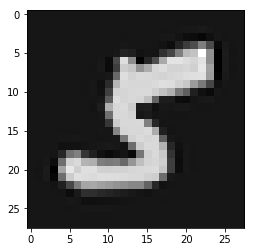

In [5]:
#Prepare data
train_data_path = r"C:\Users\Being_Aerys\PycharmProjects\Machine_Learning_Algorithms_Collection\Supervised_Methods\Perceptron\Data\pa2_train.csv"
validation_data_path = r"C:\Users\Being_Aerys\PycharmProjects\Machine_Learning_Algorithms_Collection\Supervised_Methods\Perceptron\Data\pa2_valid.csv"
test_data_path = r"C:\Users\Being_Aerys\PycharmProjects\Machine_Learning_Algorithms_Collection\Supervised_Methods\Perceptron\Data\pa2_test.csv"

preprocessing = Preprocessing()

scaler_used_for_features, training_features, training_targets = preprocessing.preprocess_train_csv(train_data_path)

validation_features, validation_targets = preprocessing.preprocess_validation_csv(scaler_used_for_features, validation_data_path)
test_features = preprocessing.preprocess_test_csv(scaler_used_for_features, test_data_path)

max_iterations_for_training = 25

vanilla_perceptron = Vanilla_Perceptron(max_iterations_for_training, training_features, training_targets, validation_features, validation_targets, test_features, scaler_used_for_features)

vanilla_perceptron.train()

print("******************************************Training ends.***********************************************")

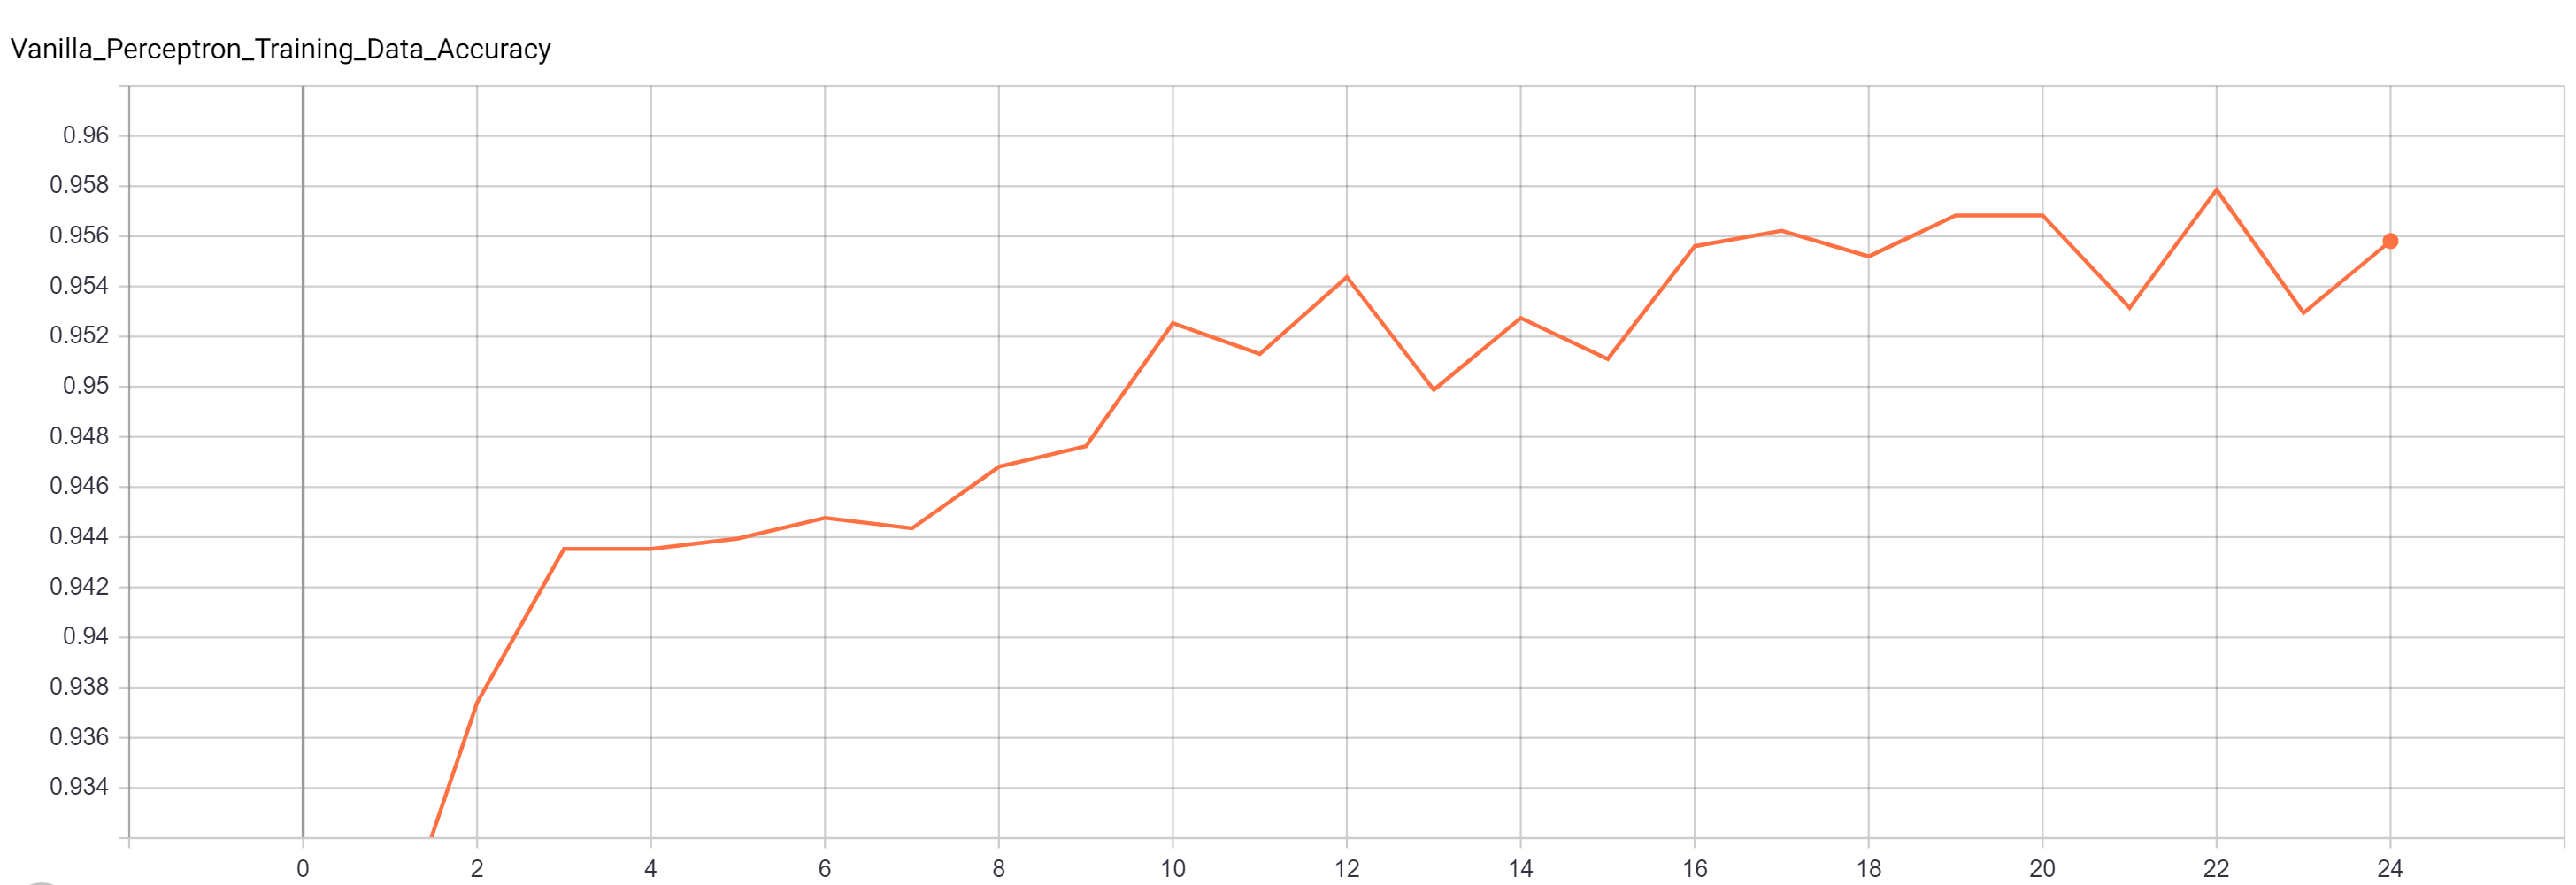

In [7]:
from IPython.display import Image
Image(filename='Images/training_accuracy.png')

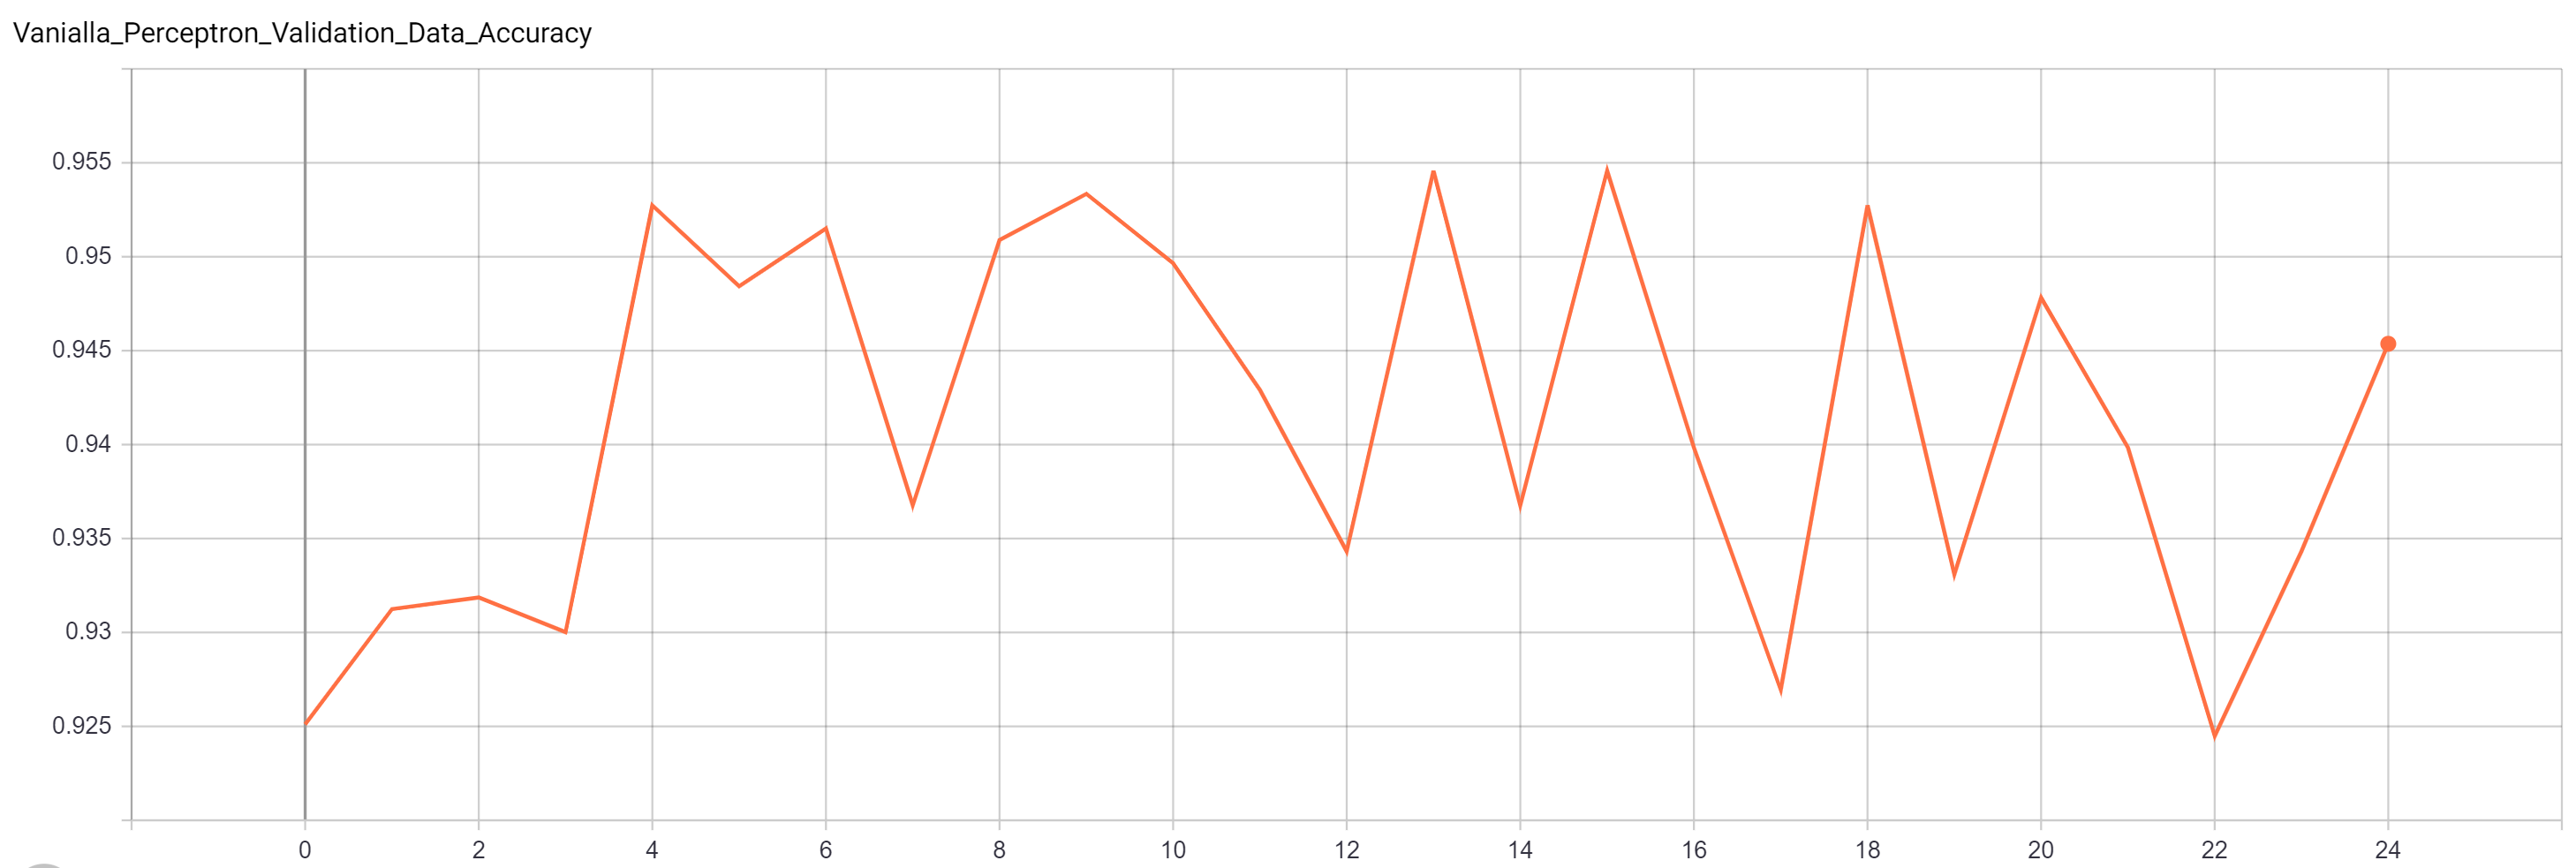

In [8]:
from IPython.display import Image
Image(filename='Images/validation_accuracy.png')

In [ ]:
#Tensorboard SummaryWriter command
#tensorboard --logdir "C:\Users\Being_Aerys\PycharmProjects\Machine_Learning_Algorithms_Collection\Supervised_Methods\Perceptron\runs" --bind_all